In [4]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# split a loaded document into sentences
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

# load dataset
filename = 'deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(100):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[go] => [geh]
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[wait] => [warte]
[begin] => [fang an]
[go on] => [mach weiter]
[hello] => [hallo]
[hurry] => [beeil dich]
[hurry] => [schnell]
[i ran] => [ich rannte]
[i see] => [ich verstehe]
[i see] => [aha]
[i try] => [ich probiere es]
[i won] => [ich hab gewonnen]
[i won] => [ich habe gewonnen]
[relax] => [entspann dich]
[shoot] => [feuer]
[shoot] => [schie]
[smile] => [lacheln]
[attack] => [angriff]
[attack] => [attacke]
[cheers] => [zum wohl]
[eat it] => [iss es]
[eat up] => [iss auf]
[freeze] => [keine bewegung]
[freeze] => [stehenbleiben]
[got it] => [verstanden]
[got it] => [aha]
[got it] => [ich habs]
[got it] => [kapiert]
[got it] => [verstanden]
[got it] => [einverstanden]
[he ran] => [er rannte]
[he ran] => [er lief]
[hop in] => [mach mit]
[hug me

In [5]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [6]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.optimizers import Adagrad
from keras.optimizers import SGD
from keras.layers import TimeDistributed
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

# define model
model_SGD = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model_SGD.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])


model_AdaGrad = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model_AdaGrad.compile(optimizer='adagrad', loss='categorical_crossentropy',metrics=['accuracy'])


# summarize defined model
# print(model.summary())
# plot_model(model, to_file='model.png', show_shapes=True)
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_SGD = model_SGD.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)
history_AdaGrad = model_AdaGrad.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)


Using TensorFlow backend.


English Vocabulary Size: 2214
English Max Length: 5
German Vocabulary Size: 3526
German Max Length: 9


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9000 samples, validate on 1000 samples
Epoch 1/30
 - 7s - loss: 7.5513 - accuracy: 0.4296 - val_loss: 7.3952 - val_accuracy: 0.4316

Epoch 00001: val_loss improved from inf to 7.39519, saving model to model.h5
Epoch 2/30
 - 5s - loss: 7.2264 - accuracy: 0.4333 - val_loss: 7.0443 - val_accuracy: 0.4316

Epoch 00002: val_loss improved from 7.39519 to 7.04434, saving model to model.h5
Epoch 3/30
 - 5s - loss: 6.8108 - accuracy: 0.4333 - val_loss: 6.5300 - val_accuracy: 0.4316

Epoch 00003: val_loss improved from 7.04434 to 6.53001, saving model to model.h5
Epoch 4/30
 - 5s - loss: 6.0380 - accuracy: 0.4333 - val_loss: 5.3527 - val_accuracy: 0.4316

Epoch 00004: val_loss improved from 6.53001 to 5.35268, saving model to model.h5
Epoch 5/30
 - 5s - loss: 4.8061 - accuracy: 0.4333 - val_loss: 4.6229 - val_accuracy: 0.4316

Epoch 00005: val_loss improved from 5.35268 to 4.62291, saving model to model.h5
Epoch 6/30
 - 5s - loss: 4.5923 - accuracy: 0.4333 - val_loss: 4.5971 - val_accur

Text(0, 0.5, 'Loss')

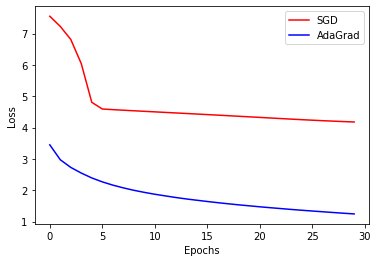

In [7]:
plt.plot(history_SGD.history['loss'],label='SGD',color = 'r')
plt.plot(history_AdaGrad.history['loss'],label='AdaGrad',color = 'b')
plt.legend(['SGD', 'AdaGrad'], loc=1)
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

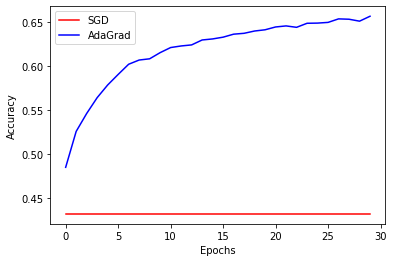

In [8]:

plt.plot(history_SGD.history['val_accuracy'],label='SGD',color = 'r')
plt.plot(history_AdaGrad.history['val_accuracy'],label='AdaGrad',color = 'b')
plt.legend(['SGD', 'AdaGrad'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')